In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft 
from scipy import signal
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index

df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


In [3]:
#drop some columns 

new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','MagnX','MagnY','MagnZ','qw','qi','qj','qk'])

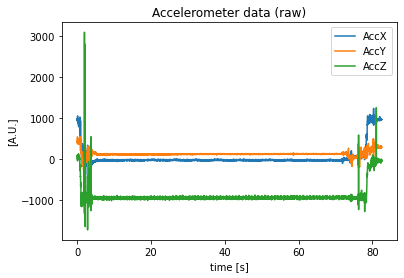

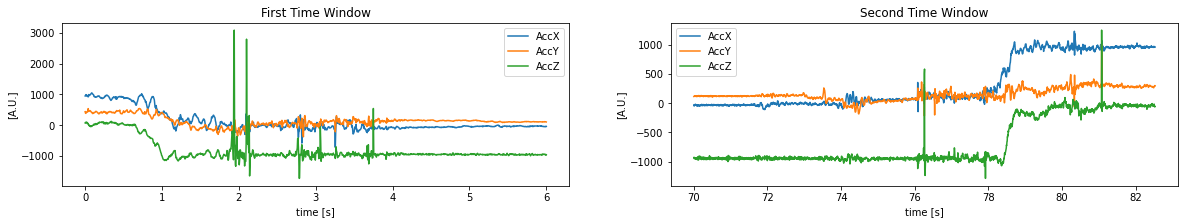

In [4]:
# now let's look at the acceleration vector by plotting its three components

new_df.plot(y=['AccX','AccY','AccZ'], title= 'Accelerometer data (raw)',ylabel='[A.U.]', xlabel='time [s]')

figure, axes = plt.subplots(1, 2, figsize=(20,3))
new_df.loc[0:6].plot(ax=axes[0],y=['AccX','AccY','AccZ'],title='First Time Window',ylabel='[A.U.]', xlabel='time [s]')
new_df.loc[70:].plot(ax=axes[1],y=['AccX','AccY','AccZ'],title='Second Time Window',ylabel='[A.U.]', xlabel='time [s]');

In [5]:
#clean up the data (we select a time intervall from 6s to 71s)

data=new_df.loc[6:71].copy()

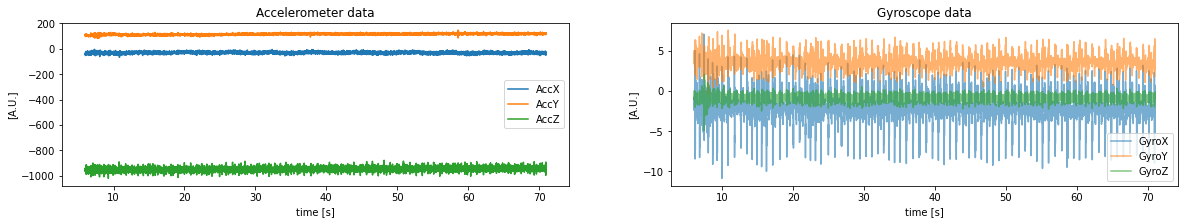

In [6]:
figure, axes = plt.subplots(1, 2, figsize=(20,3))
data.plot(ax=axes[0],y=['AccX','AccY','AccZ'],title= 'Accelerometer data',ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['GyroX','GyroY','GyroZ'],title= 'Gyroscope data',alpha=0.6,ylabel='[A.U.]', xlabel='time [s]');

In [7]:
#normalize dataset

data=(data-data.mean())/data.std()
data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04
mean,4.263748e-15,-9.961538e-15,-1.695290e-13,1.423158e-15,5.274981e-15,-9.639743e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.079647e+00,-5.775790e+00,-4.980567e+00,-6.022103e+00,-5.411663e+00,-1.032785e+01
25%,-6.497357e-01,-6.151477e-01,-6.053065e-01,-4.225166e-01,-5.689300e-01,-6.295424e-01
50%,1.131693e-02,4.592635e-02,-2.610531e-02,-4.642540e-02,-7.435336e-02,2.731555e-02
75%,6.637845e-01,6.643504e-01,5.489289e-01,4.341358e-01,4.408304e-01,6.455343e-01
max,3.788761e+00,5.611743e+00,4.761680e+00,6.253106e+00,5.221741e+00,7.407303e+00


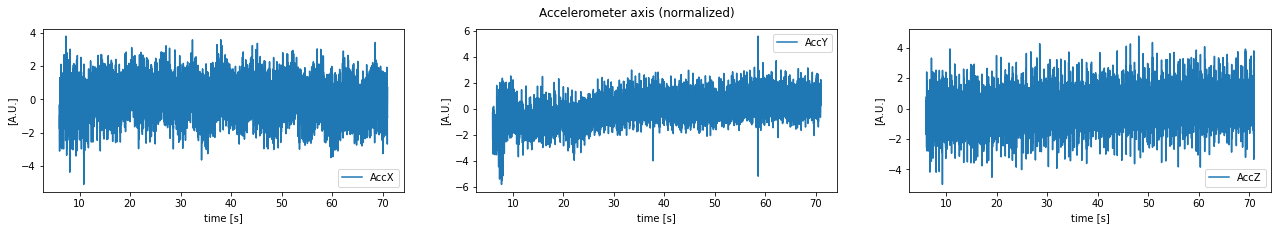

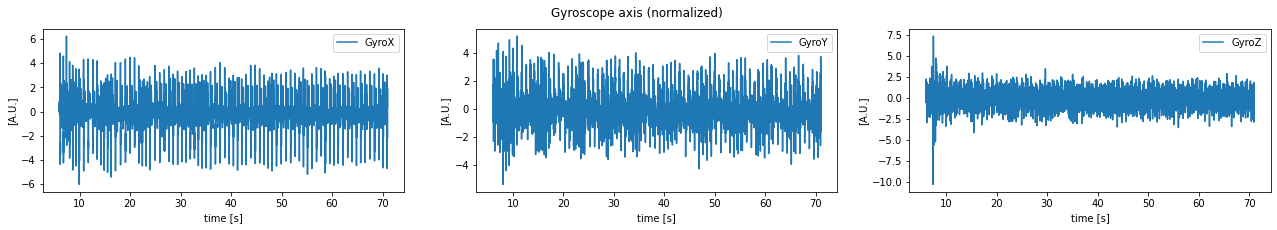

In [8]:
#accelerometer plots

figure, axes = plt.subplots(1, 3, figsize=(22,3))
figure.suptitle('Accelerometer axis (normalized)')
data.plot(ax=axes[0],y=['AccX'], ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['AccY'],ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['AccZ'], ylabel='[A.U.]', xlabel='time [s]')


#gyroscope plots

figure, axes = plt.subplots(1, 3, figsize=(22,3))
figure.suptitle('Gyroscope axis (normalized)')
data.plot(ax=axes[0],y=['GyroX'], ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[1],y=['GyroY'],ylabel='[A.U.]', xlabel='time [s]')
data.plot(ax=axes[2],y=['GyroZ'], ylabel='[A.U.]', xlabel='time [s]');

 Accelerometer PCA:
Percentage of variance due to the selected component: 50.88%

 Gyroscope PCA:
Percentage of variance due to the selected component: 59.61%


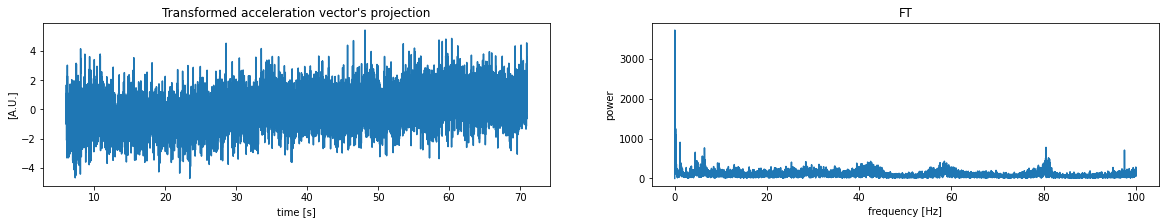

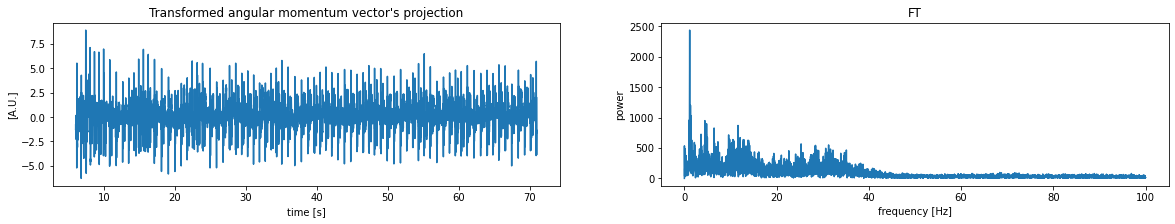

In [9]:
#performing PCA

acc_columns = ['AccX','AccY','AccZ']
gyro_columns= ['GyroX','GyroY','GyroZ']
total_columns = acc_columns + gyro_columns

sampling_rate = 200 
sample_spacing = 1/sampling_rate

pca=PCA(n_components=1) # we seek a single signal

print(' Accelerometer PCA:')

pca.fit(data[acc_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
accT=pca.transform(data[acc_columns]).reshape(-1)

accT_FT=fft.fft(accT)
accT_FT_freq=fft.fftfreq(accT.size,sample_spacing)
N = int(accT_FT_freq.size/2) #ignoring negative frequencies since input is real valued
accT_freq_pos = accT_FT_freq[:N]
accT_FT_pos = np.abs(accT_FT[:N])

with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,accT)
    axs[0].set_title("Transformed acceleration vector's projection")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(accT_FT_freq[:N],np.abs(accT_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power')
    
    
print('\n Gyroscope PCA:')

pca.fit(data[gyro_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
gyrT=pca.transform(data[gyro_columns]).reshape(-1)


gyrT_FT=fft.fft(gyrT)
gyrT_FT_freq=fft.fftfreq(accT.size,sample_spacing)
N = int(gyrT_FT_freq.size/2) 
gyrT_freq_pos = gyrT_FT_freq[:N]
gyrT_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,gyrT)
    axs[0].set_title("Transformed angular momentum vector's projection")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(gyrT_FT_freq[:N],np.abs(gyrT_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power')

 Accelerometer and Gyroscope PCA:
Percentage of variance due to the selected component: 30.77%


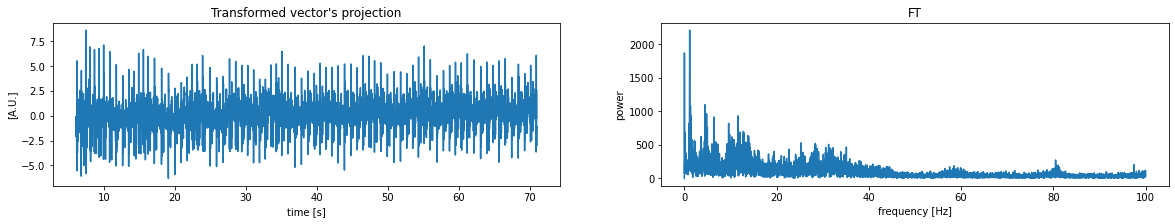

In [10]:
#performing PCA on both sensors

print(' Accelerometer and Gyroscope PCA:')

pca.fit(data[total_columns])
print("Percentage of variance due to the selected component: {:.2%}".format(pca.explained_variance_ratio_[0]))
totalT=pca.transform(data[total_columns]).reshape(-1)

totalT_FT=fft.fft(totalT)
totalT_FT_freq=fft.fftfreq(totalT.size,sample_spacing)
N = int(totalT_FT_freq.size/2) 
totalT_freq_pos = totalT_FT_freq[:N]
totalT_FT_pos = np.abs(totalT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,totalT)
    axs[0].set_title("Transformed vector's projection")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(totalT_FT_freq[:N],np.abs(totalT_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power')

In [11]:
#let's see if the selected componet of gyroscope drifts

drift=np.polyfit(data.index,gyrT,1)
print(drift)

gyr_clean=gyrT-(drift[0]*data.index + drift[1])

[ 0.00391009 -0.15053848]


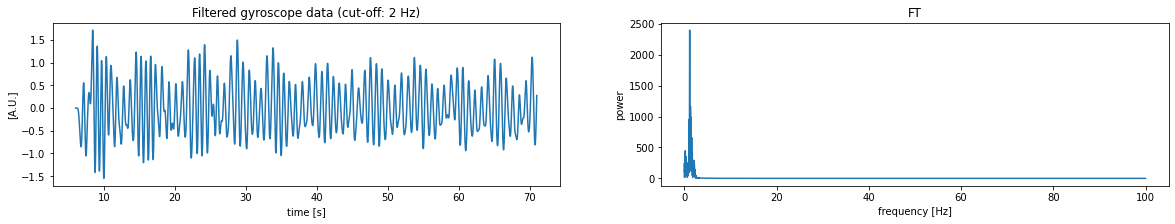

In [12]:
#let's try to denoising the selected PCA component of the gyroscope via low-pass Butter filter in order to
#see the heart rate

order=10 #order of the filter
trashold=2 #cut-off freq

sos = signal.butter(order, trashold, 'lp', fs=sampling_rate, output='sos')

filt_gyro = signal.sosfilt(sos, gyr_clean)

filt_gyro_FT=fft.fft(filt_gyro)
filt_gyro_FT_freq=fft.fftfreq(filt_gyro.size,sample_spacing)
N = int(filt_gyro_FT_freq.size/2) 
filt_gyro_freq_pos = gyrT_FT_freq[:N]
filt_gyro_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_gyro)
    axs[0].set_title("Filtered gyroscope data (cut-off: 2 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_gyro_FT_freq[:N],np.abs(filt_gyro_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');


Fit parametres for HR:
 [ 1.74108725e+03  1.15503788e+00 -1.41516246e-02  4.49155146e+02] 

Heart rate estimated: 69.30227262481347 +/- -0.8490974770590132 bpm
Percentage of error: 1.225208705139918 %


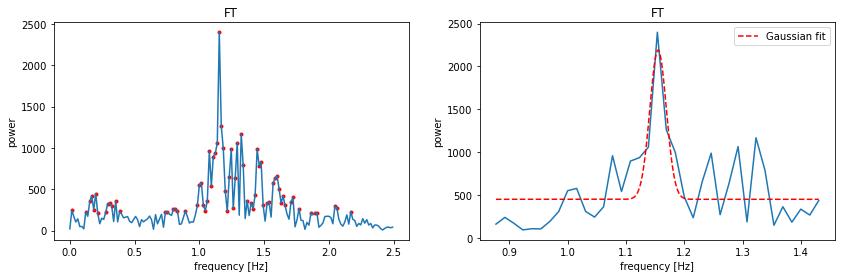

In [13]:
x=filt_gyro_FT_freq[:N]
y=np.abs(filt_gyro_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])


#Heart rate estimation

def f(x,a,b,c,d):
    return a*np.exp(-pow(x-b,2)/(2*pow(c,2)))+d

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')


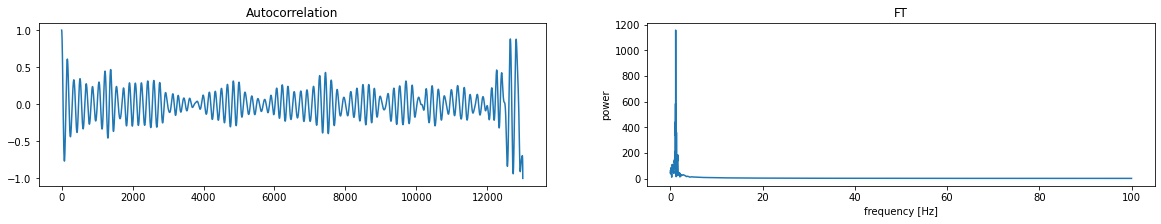

In [14]:
#let's see autocorrelation on the filred data with cut-off: 2 Hz

gyr_series=pd.Series(filt_gyro)
autocorr=[gyr_series.autocorr(i) for i in range(len(gyr_series)-1)]

autocorr_FT=fft.fft(autocorr)
autocorr_FT_freq=fft.fftfreq(len(autocorr),1/200)
N = int(autocorr_FT_freq.size/2) 
autocorr_freq_pos = autocorr_FT_freq[:N]
autocorr_FT_pos = np.abs(autocorr_FT[:N])

with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(autocorr)
    axs[0].set_title("Autocorrelation")
    axs[1].plot(autocorr_FT_freq[:N],np.abs(autocorr_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');


Fit parametres for HR:
 [ 4.73689134e+02  1.14060710e+00 -3.82799374e-02  1.24849296e+02] 

Heart rate estimated: 68.43642628302626 +/- -2.2967962432200975 bpm
Percentage of error: 3.356101959096238 %


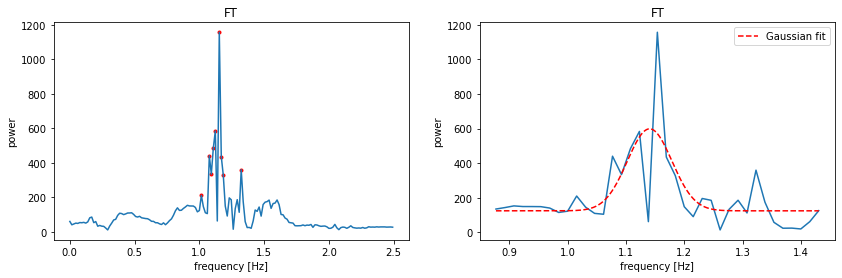

In [15]:
x=autocorr_FT_freq[:N]
y=np.abs(autocorr_FT[:N])

zoom=np.where(x<2.5)
power_trashold=200

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])


#Heart rate estimation via autocorrelation

cardiac=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[cardiac], y[cardiac]) 
x_range=np.linspace(x[cardiac].min(),x[cardiac].max(),1000) 

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[cardiac],y[cardiac])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('Fit parametres for HR:\n', popt, '\n')
print('Heart rate estimated:', 60*popt[1], '+/-', popt[2]*60, 'bpm' )
print('Percentage of error:', err_perc, '%')

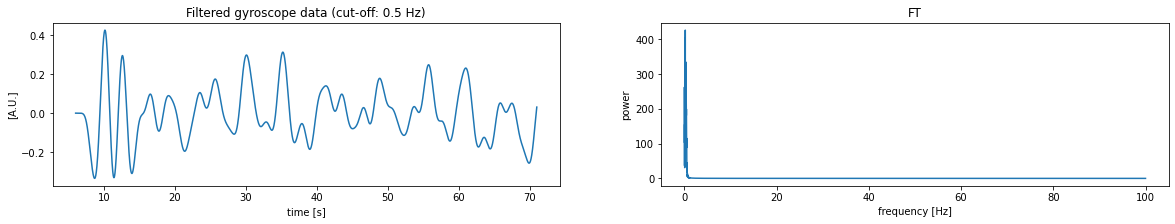

In [16]:
#let's try to denoising the selected PCA component of the gyroscope via low-pass Butter filter in order to
#see the breath rate

order=10 #order of the filter
trashold=0.5 #cut-off freq

sos = signal.butter(order, trashold, 'lp', fs=sampling_rate, output='sos')

filt_gyro = signal.sosfilt(sos, gyr_clean)

filt_gyro_FT=fft.fft(filt_gyro)
filt_gyro_FT_freq=fft.fftfreq(filt_gyro.size,sample_spacing)
N = int(filt_gyro_FT_freq.size/2) 
filt_gyro_freq_pos = gyrT_FT_freq[:N]
filt_gyro_FT_pos = np.abs(gyrT_FT[:N])


with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(data.index,filt_gyro)
    axs[0].set_title("Filtered gyroscope data (cut-off: 0.5 Hz)")
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('[A.U.]')
    axs[1].plot(filt_gyro_FT_freq[:N],np.abs(filt_gyro_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');


Fit parametres for BR:
 [ 3.29196016e+02  2.59314400e-01 -2.56229046e-01 -9.31655675e+01] 

Breath rate estimated: 15.558863990432707 +/- 15.37374277381885 bpm
Percentage of error: 98.81018809131766 %


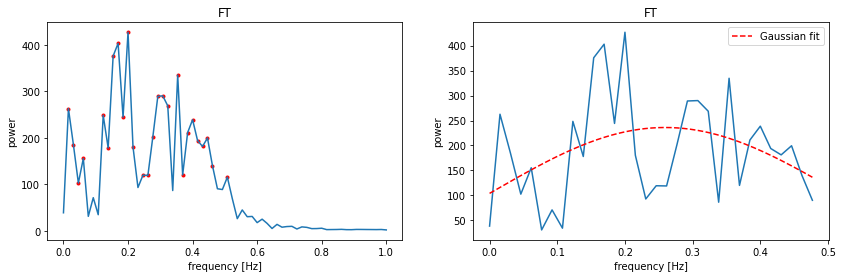

In [17]:
x=filt_gyro_FT_freq[:N]
y=np.abs(filt_gyro_FT[:N])

zoom=np.where(x<1)
power_trashold=100

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])


#breath rate estimation

breath=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[breath], y[breath]) 
x_range=np.linspace(x[breath].min(),x[breath].max(),1000) 


fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[breath],y[breath])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('Fit parametres for BR:\n', popt, '\n')
print('Breath rate estimated:', 60*popt[1], '+/-', abs(popt[2]*60), 'bpm' )
print('Percentage of error:', err_perc, '%')

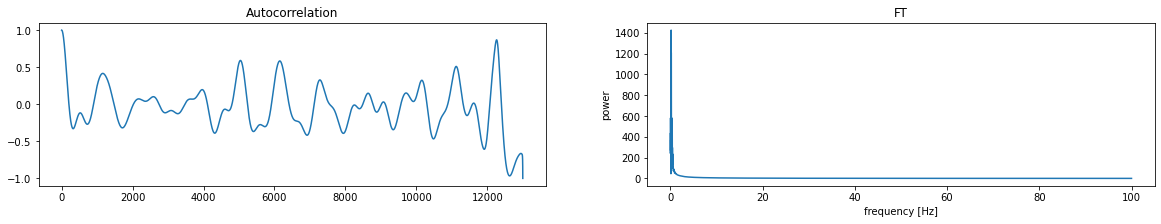

In [18]:
#let's see autocorrelation on filtred data cut-off 0.5 Hz

gyr_series=pd.Series(filt_gyro)
autocorr=[gyr_series.autocorr(i) for i in range(len(gyr_series)-1)]

autocorr_FT=fft.fft(autocorr)
autocorr_FT_freq=fft.fftfreq(len(autocorr),1/200)
N = int(autocorr_FT_freq.size/2) 
autocorr_freq_pos = autocorr_FT_freq[:N]
autocorr_FT_pos = np.abs(autocorr_FT[:N])

with plt.rc_context({"figure.figsize" : (20,3)}):
    fig,axs = plt.subplots(1,2)
    axs[0].plot(autocorr)
    axs[0].set_title("Autocorrelation")
    axs[1].plot(autocorr_FT_freq[:N],np.abs(autocorr_FT[:N]))
    axs[1].set_title("FT")
    axs[1].set_xlabel('frequency [Hz]')
    axs[1].set_ylabel('power');

Fit parametres for BR:
 [7.17681424e+02 1.80635479e-01 2.40245923e-02 3.20183838e+02] 

Breath rate estimated: 10.8381287253003 +/- 1.441475535994505 bpm
Percentage of error: 13.300040740700515 %


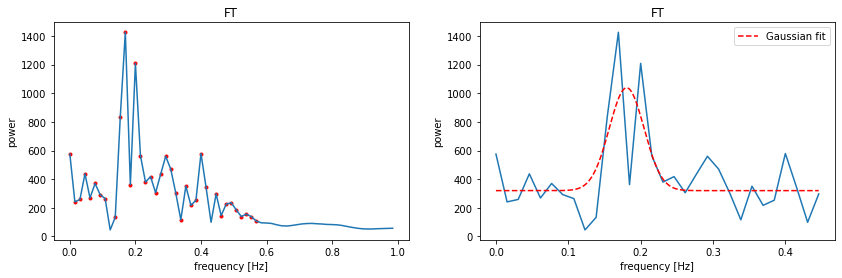

In [19]:
x=autocorr_FT_freq[:N]
y=np.abs(autocorr_FT[:N])

zoom=np.where(x<1)
power_trashold=100

peak=np.where(y==y.max())
peaks=np.array(x[np.where(y>=power_trashold)])
power_peaks=np.array(y[np.where(y>=power_trashold)])


#breth rate estimation via autocorrelation

breath=np.where(abs(x-x[peak])<=1/np.sqrt(12))

popt, pcov = curve_fit(f, x[breath], y[breath]) 
x_range=np.linspace(x[breath].min(),x[breath].max(),1000) 


fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x[zoom],y[zoom])
ax[0].scatter(peaks,power_peaks,marker='.',color='red')
ax[0].set_title('FT')
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('power')
ax[1].plot(x[breath],y[breath])
ax[1].plot(x_range, f(x_range,*popt), c='red', linestyle='dashed' ,label='Gaussian fit',)
ax[1].legend(loc='best')
ax[1].set_title('FT')
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('power');

err_perc=abs(popt[2]*100/popt[1])

print('Fit parametres for BR:\n', popt, '\n')
print('Breath rate estimated:', 60*popt[1], '+/-', abs(popt[2]*60), 'bpm' )
print('Percentage of error:', err_perc, '%')